In [1]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
backend = provider.get_backend("ibmq_jakarta")


configrc.store_credentials:WARNING:2022-06-27 18:55:27,826: Credentials already present. Set overwrite=True to overwrite.


In [2]:
print(IBMQ.providers())

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='ornl', project='phy147')>]


In [23]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    counter = 0
    temp = [] 
    for key in db:
        temp.append(key)
    print(counter)
    dbfile.close()
    return temp

data=loadData('FGRAFS_controls_N64.p')
temp = []
for i in data:
    for j in range(int(4)):
        temp.append(i)
print(len(temp), " " , len(data))

0
256   64


Job Status: job has successfully run
1 :  0.222306909168671
Job Status: job has successfully run
[ 4.36023466e-09 -3.11742616e-10  4.59006646e-01  9.57906833e-11]


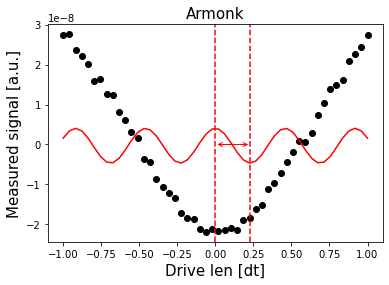

Time taken: 72.4015519618988


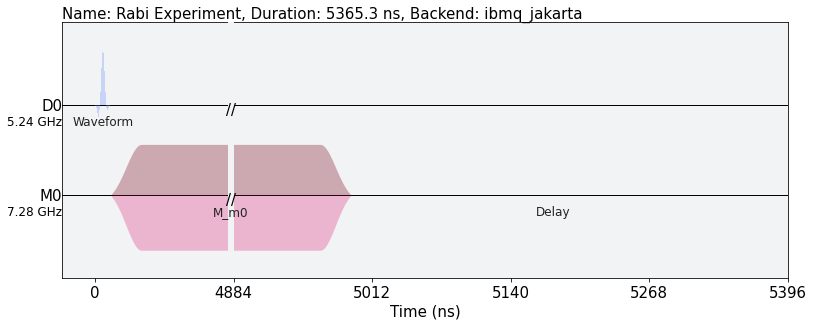

In [24]:
import time

# Generate circuits and run on simulator
t = time.time()
test= [x**2 for x in range(64)]
signal = Su22.Custom_Fgp('low_freq',data,backend)
#print(signal.input)
#print(signal.norm)
print('Time taken:', time.time() - t)
signal.draw()

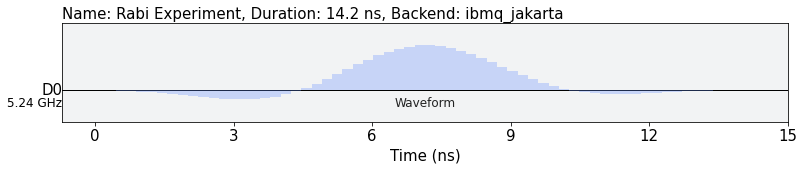

In [25]:
signal.Create_Pulse().draw(backend=backend)

In [13]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

drive_amps_2,rabi_values_2 = signal.Cali(50,signal.length)

Job Status: job has successfully run


[-8.11542538e-08 -7.29815285e-09  5.99661886e-01  9.24029438e-10]


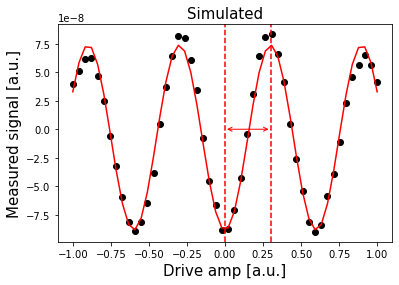

In [14]:
fit_params_2, y_fit_2 = fit_function(drive_amps_2,
                                 rabi_values_2, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-8, 1, 0.5, 0])

plt.scatter(drive_amps_2, rabi_values_2, color='black')
plt.plot(drive_amps_2, y_fit_2, color='red')
print(fit_params_2)
drive_period_2 = fit_params_2[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period_2/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period_2/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period_2/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.title("Simulated", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [7]:
pi_amp_2 = abs(drive_period_2 / 2)
print(f"Pi Amplitude = {pi_amp_2}")
signal.pi_p = pi_amp_2

Pi Amplitude = 0.3047126597469888


In [4]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time

# Generate circuits and run on simulator
t = time.time()
circ = QuantumCircuit(1)
circ = signal.add_as_gate(circ,[0])
qst_bell = state_tomography_circuits(circ,[0])
qst_bell[2].draw('mpl')
job = qk.execute(qst_bell, backend=backend, shots=5000)
print('Time taken:', time.time() - t)

NameError: name 'signal' is not defined

In [26]:
q2 = QuantumRegister(1)
bell = QuantumCircuit(q2)
bell.x(q2[0])
print(bell)

job = qk.execute(bell, backend=Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(bell)
print(psi_bell)

t = time.time()
circ = QuantumCircuit(1)
circ = signal.add_as_gate(circ,[0])
#circ.x(0)
qst_bell = state_tomography_circuits(circ,[0])
qst_bell[2].draw('mpl')
print(qst_bell[2])
job = qk.execute(qst_bell, backend=backend, shots=8192)
print('Time taken:', time.time() - t)

tomo_bell = StateTomographyFitter(job.result(), qst_bell)
rho_bell = tomo_bell.fit()

      ┌───┐
q154: ┤ X ├
      └───┘
Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
      ┌──────────┐ ░ ┌─┐
   q: ┤ low_freq ├─░─┤M├
      └──────────┘ ░ └╥┘
c4: 1/════════════════╩═
                      0 
Time taken: 9.032092332839966


In [27]:
print(rho_bell)

[[0.91809082+0.j         0.01599121+0.19750977j]
 [0.01599121-0.19750977j 0.08190918+0.j        ]]


In [28]:
temp = np.tensordot(psi_bell,np.transpose(psi_bell),0)

In [29]:
print(temp)

[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [30]:
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity =', F_bell)

Fit Fidelity = 0.08190917968750026


In [6]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time
q2=3
control = QuantumCircuit(q2)
test = QuantumCircuit(q2)
jobt_list = []
jobc_list = []
results = []
temp = []
for i in range(q2):
    temp.append(i)
for i in range(q2):
    control.x(i)
    #print(control)
    job = qk.execute(control, backend=Aer.get_backend('statevector_simulator'))
    jobc_list.append(job)
    test = signal.add_as_gate(test,[i])
    print(test)
    qst = state_tomography_circuits(test,temp)
    job = qk.execute(qst, backend=backend, shots=5000)
    result = StateTomographyFitter(job.result(), qst)
    jobt_list.append(result)

     ┌──────────┐
q_0: ┤ low_freq ├
     └──────────┘
q_1: ────────────
                 
q_2: ────────────
                 
     ┌──────────┐
q_0: ┤ low_freq ├
     ├──────────┤
q_1: ┤ low_freq ├
     └──────────┘
q_2: ────────────
                 
     ┌──────────┐
q_0: ┤ low_freq ├
     ├──────────┤
q_1: ┤ low_freq ├
     ├──────────┤
q_2: ┤ low_freq ├
     └──────────┘


In [7]:
t = time.time()
rho_list = []
for i in jobt_list:
    rho_list.append(i.fit())
print('Time taken:', time.time() - t)

Time taken: 0.09508752822875977


In [12]:
print(jobc_list[2].result().get_statevector())

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j],
            dims=(2, 2, 2))


[0.27837838056470793, 0.007590632838180955, 0.0004415242641696488]


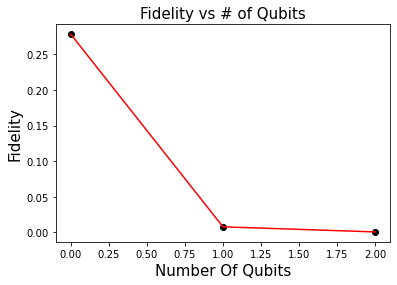

In [11]:
F_bell = []
for i in range(len(jobt_list)):
    F_bell.append(state_fidelity(jobc_list[i].result().get_statevector(), rho_list[i]))
print(F_bell)
plt.scatter(temp, F_bell, color='black')
plt.plot(temp, F_bell, color='red')
plt.xlabel("Number Of Qubits", fontsize=15)
plt.title("Fidelity vs # of Qubits", fontsize=15)
plt.ylabel("Fidelity", fontsize=15)
plt.show()